In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))
import os
#import xgboost as xgb
#import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import json
import ast
import eli5
from functools import reduce
import warnings
from sklearn.metrics import mean_squared_error
from scipy import stats
from math import sqrt
from lightgbm import plot_tree
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK
from hyperopt.pyll.stochastic import sample
import time
import gc
warnings.filterwarnings('ignore')
#import shap

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [36]:
train = pd.read_csv('FE_train.csv')
test  = pd.read_csv('FE_test.csv')
gc.collect()

7

In [37]:
#categorical feature to one-hot
categorical_features = ['city', 'building_type', 'building_use', 'town']
for i in categorical_features:
    train = train.join(pd.get_dummies(train[i], prefix = i + '_'))
    test = test.join(pd.get_dummies(train[i], prefix = i + '_'))
    train.drop(i, axis = 1, inplace =True)
    test.drop(i, axis = 1, inplace =True)

In [38]:
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [39]:
def Submission(Ids, preds):
    file_name = datetime.datetime.today().strftime('%m-%d-%H-%M')
    submission = pd.DataFrame({'building_id' : Ids, 'total_price' : preds})
    if not os.path.isdir('Submission'):
        os.makedirs('Submission')
    submission.to_csv('Submission/' + file_name + '.csv', index= False)

In [40]:
def lgb_model(split_num, train, test, features, stratified = False):
    if stratified:
        kf = StratifiedKFold(n_splits = split_num, random_state = 42, shuffle = True)
    else :
        kf = KFold(n_splits=split_num, shuffle=True,random_state=42)
    train['total_price_log'] = np.log1p(train['total_price'])
    feature_importance_df = pd.DataFrame()
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    
    param ={
        'n_estimators': 10000, 'max_depth' : 5, 'num_leaves' :30,         
        'objective': 'regression',   'metric':'rmse',   
        'learning_rate': 0.01,      'boosting': 'gbdt',     'min_data_in_leaf': 10,
        'feature_fraction': 0.9,    'bagging_freq':1,       'bagging_fraction': 0.9,     'importance_type': 'gain',
        'lambda_l1': 0.2,  'subsample': .8,   'colsample_bytree': .9
    }
    for fold_, (trn_idx, val_idx) in enumerate(kf.split(train[features].values,train['total_price_log'].values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][features], label= train['total_price_log'].iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][features], label= train['total_price_log'].iloc[val_idx])
        
        
        clf = lgb.train(params= param, train_set= trn_data, valid_sets= [trn_data, val_data], verbose_eval=200, early_stopping_rounds= 1000)
        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)
        predictions += clf.predict(test[features], num_iteration = clf.best_iteration) / kf.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df['feature']    = features
        fold_importance_df['importance'] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
        fold_importance_df['fold']       = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    print('CV scrore : {}'.format(sqrt(mean_squared_error(train['total_price_log'], oof))))
    display_importances(feature_importance_df)
    return predictions


Training until validation scores don't improve for 1000 rounds.
[200]	training's rmse: 0.413743	valid_1's rmse: 0.413509
[400]	training's rmse: 0.290598	valid_1's rmse: 0.295833
[600]	training's rmse: 0.258293	valid_1's rmse: 0.267079
[800]	training's rmse: 0.242566	valid_1's rmse: 0.254001
[1000]	training's rmse: 0.233181	valid_1's rmse: 0.246421
[1200]	training's rmse: 0.225751	valid_1's rmse: 0.240767
[1400]	training's rmse: 0.219851	valid_1's rmse: 0.236494
[1600]	training's rmse: 0.214975	valid_1's rmse: 0.233176
[1800]	training's rmse: 0.210764	valid_1's rmse: 0.230477
[2000]	training's rmse: 0.206954	valid_1's rmse: 0.228102
[2200]	training's rmse: 0.203292	valid_1's rmse: 0.225955
[2400]	training's rmse: 0.199992	valid_1's rmse: 0.224046
[2600]	training's rmse: 0.197024	valid_1's rmse: 0.222414
[2800]	training's rmse: 0.194227	valid_1's rmse: 0.220946
[3000]	training's rmse: 0.19151	valid_1's rmse: 0.219492
[3200]	training's rmse: 0.18907	valid_1's rmse: 0.218287
[3400]	trainin

[7200]	training's rmse: 0.151956	valid_1's rmse: 0.212017
[7400]	training's rmse: 0.150536	valid_1's rmse: 0.211631
[7600]	training's rmse: 0.149179	valid_1's rmse: 0.211265
[7800]	training's rmse: 0.14785	valid_1's rmse: 0.210923
[8000]	training's rmse: 0.146515	valid_1's rmse: 0.210551
[8200]	training's rmse: 0.145208	valid_1's rmse: 0.210247
[8400]	training's rmse: 0.143945	valid_1's rmse: 0.209923
[8600]	training's rmse: 0.142685	valid_1's rmse: 0.209608
[8800]	training's rmse: 0.141478	valid_1's rmse: 0.209353
[9000]	training's rmse: 0.140268	valid_1's rmse: 0.20908
[9200]	training's rmse: 0.139096	valid_1's rmse: 0.208797
[9400]	training's rmse: 0.137947	valid_1's rmse: 0.208519
[9600]	training's rmse: 0.136822	valid_1's rmse: 0.208276
[9800]	training's rmse: 0.135667	valid_1's rmse: 0.208012
[10000]	training's rmse: 0.134567	valid_1's rmse: 0.207799
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.134567	valid_1's rmse: 0.207799
Training until validatio

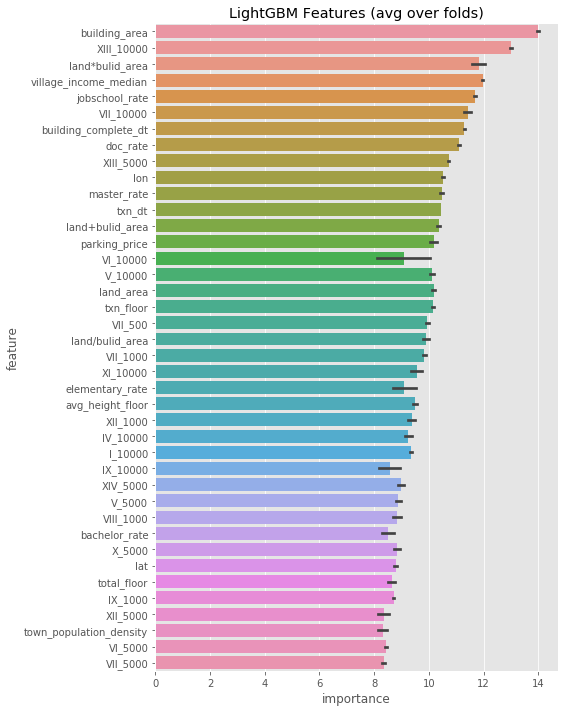

In [41]:
begin = time.time()
features = [i for i in train.columns if i not in ['building_id', 'total_price','total_price_log']] 
prediction = lgb_model(5, train, test, features, stratified = False)
prediction = np.expm1(prediction)
print((time.time() - begin) / 60)

In [44]:
print(prediction)

[10871588.21763064  3673406.17060819  8961702.84239375 ...
   943317.75260987  3002678.99033299  2934505.2371289 ]


In [45]:
Submission(test['building_id'],prediction)

In [ ]:
#prediction = lgb_model(5, train, test, features, stratified = False)
#prediction = np.expm1(prediction)